## Group Project
#### Andrew Long
#### William Jinkins
#### Tyler Borer

Our code is significantly different than any that we have seen on Kaggle, when dealing with these datasets. Unlike the previous code examples, we take the extra step of stemming and lemmatizing the data. Our goal is also slightly different, as well. We would like to not only predict if an article is fake or real, but we would also like to add additional classifications, such as propoganda.

This program will combine the two data sets. There are a total of 3 data sets. 
Overall program flow - 
* Load needed libraries
* Import the data and combine into single dataframe
* Clean data by removing duplicates, lower casing text, removing punctuation, removing stop words, stemming and lemmatizing, & removing numbers and special characters
* Examine the data and provide visualizations
* Data is then tokenized in 2 different ways


In [1]:
### Libraries Used

import pandas as pd
import numpy as np
import re
import nltk
import matplotlib.pyplot as plt
import string
import gensim
import gensim.corpora as corpora
#!pip install pyldavis
import pyLDAvis
import pyLDAvis.gensim

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from gensim import corpora, models
from gensim.models import CoherenceModel

ModuleNotFoundError: No module named 'pyLDAvis'

### Importing Datasets and Combining Into One

In [ ]:
### Importing first dataset and looking at top 5 rows
#Used the pandas read_csv function to import from folder "data"

df1 = pd.read_csv("data/Fake.csv")
df1.head()

In [3]:
### Importing second dataset and looking at top 5 rows
#Used the pandas read_csv function to import from folder "data"
df2 = pd.read_csv("data/True.csv")
df2.head()

### column names are the same as df1

title  \
0  As U.S. budget fight looms, Republicans flip t...   
1  U.S. military to accept transgender recruits o...   
2  Senior U.S. Republican senator: 'Let Mr. Muell...   
3  FBI Russia probe helped by Australian diplomat...   
4  Trump wants Postal Service to charge 'much mor...   

                                                text       subject  \
0  WASHINGTON (Reuters) - The head of a conservat...  politicsNews   
1  WASHINGTON (Reuters) - Transgender people will...  politicsNews   
2  WASHINGTON (Reuters) - The special counsel inv...  politicsNews   
3  WASHINGTON (Reuters) - Trump campaign adviser ...  politicsNews   
4  SEATTLE/WASHINGTON (Reuters) - President Donal...  politicsNews   

                 date  
0  December 31, 2017   
1  December 29, 2017   
2  December 31, 2017   
3  December 30, 2017   
4  December 29, 2017

In [4]:
### Importing third dataset and looking at top 5 rows
#Used the pandas read_csv function to import from folder "data"

df3 = pd.read_csv("data/fake_or_real_news.csv")
df3.head()

### column names are slightly different

Unnamed: 0                                              title  \
0        8476                       You Can Smell Hillary’s Fear   
1       10294  Watch The Exact Moment Paul Ryan Committed Pol...   
2        3608        Kerry to go to Paris in gesture of sympathy   
3       10142  Bernie supporters on Twitter erupt in anger ag...   
4         875   The Battle of New York: Why This Primary Matters   

                                                text label  
0  Daniel Greenfield, a Shillman Journalism Fello...  FAKE  
1  Google Pinterest Digg Linkedin Reddit Stumbleu...  FAKE  
2  U.S. Secretary of State John F. Kerry said Mon...  REAL  
3  — Kaydee King (@KaydeeKing) November 9, 2016 T...  FAKE  
4  It's primary day in New York and front-runners...  REAL

Note df1 and df2 have the same column names. df3 had different column names. 
If want to combine all three data frames, then will need to reduce df1 and df2 by dropping date and subject. The unnamed column in df3 will also need to be removed. 

In [5]:
print("The shape of Fake data is -",df1.shape)
print("The shape of True data is -",df2.shape)
print("The shape of the second combined data set is -",df3.shape)

The shape of Fake data is - (23481, 4)
The shape of True data is - (21417, 4)
The shape of the second combined data set is - (6335, 4)


Data Frame 3 is the cobmined data set which has true and fake data. It is a much smaller dataset. df1 and df2 are approximately the same size. This is important for our use so we are not solving a rare event model for prediction. 

In [6]:
### Assigning new label column to df1 and df2

label_fake = ["1"] * len(df1)
df1['label'] = label_fake
#print(df1.head())
label_real = ["0"] * len(df2)
df2['label'] = label_real
#print(df2.head())

### Changing 'label' column in df3 to binary values

df3['label'] = df3['label'].str.replace('FAKE', '1')
df3['label'] = df3['label'].str.replace('REAL', '0')
#df3.head()

In [7]:
### Combining df1 and df2

combined_df1_df2 = pd.concat([df1, df2], axis=0).reset_index(drop = True)
combined_df1_df2 = combined_df1_df2.drop(['subject', 'date'], axis= 1)
#combined_df1_df2.tail()
#print(combined_df1_df2.shape)

### Adding df3 to dataframe

news = pd.concat([combined_df1_df2, df3[df3.columns[1:]]]).reset_index(drop = True)
#news = df3[df3.columns[1:]]
news.tail(10)

title  \
51223  Will the Media Reset After the Election or Are...   
51224  DOJ COMPLAINT: Comey Under Fire Over Partisan ...   
51225  GOP Senator David Perdue Jokes About Praying f...   
51226  Radio Derb Is On The Air–Leonardo And Brazil’s...   
51227  Assange claims ‘crazed’ Clinton campaign tried...   
51228  State Department says it can't find emails fro...   
51229  The ‘P’ in PBS Should Stand for ‘Plutocratic’ ...   
51230  Anti-Trump Protesters Are Tools of the Oligarc...   
51231  In Ethiopia, Obama seeks progress on peace, se...   
51232  Jeb Bush Is Suddenly Attacking Trump. Here's W...   

                                                    text label  
51223  Written by Peter Van Buren   venerable New Yor...     1  
51224  DOJ COMPLAINT: Comey Under Fire Over Partisan ...     1  
51225  The freshman senator from Georgia quoted scrip...     0  
51226                                                        1  
51227  Julian Assange has claimed the Hillary Clinton...     1  
51228  The State Department told the Republican Natio...     0  
51229  The ‘P’ in PBS Should Stand for ‘Plutocratic’ ...     1  
51230   Anti-Trump Protesters Are Tools of the Oligar...     1  
51231  ADDIS ABABA, Ethiopia —President Obama convene...     0  
51232  Jeb Bush Is Suddenly Attacking Trump. Here's W...     0

In [8]:
#find the shape of the current news data frame
#this will be used to help determine number of duplicates
dirty = news.shape
print(dirty)

(51233, 3)


### Cleaning the data

In [9]:
### Removing duplicates
#This step is going to examine the text column and remove duplicates. 
#keeping only the first occurrence of each set of duplicates, and modifies the original df in place 
#resulting DataFrame will have a continuous index starting from 0

news.drop_duplicates(subset= ['text'], keep = 'first', inplace= True, ignore_index = True)
news.head(10)

title  \
0   Donald Trump Sends Out Embarrassing New Year’...   
1   Drunk Bragging Trump Staffer Started Russian ...   
2   Sheriff David Clarke Becomes An Internet Joke...   
3   Trump Is So Obsessed He Even Has Obama’s Name...   
4   Pope Francis Just Called Out Donald Trump Dur...   
5   Racist Alabama Cops Brutalize Black Boy While...   
6   Fresh Off The Golf Course, Trump Lashes Out A...   
7   Trump Said Some INSANELY Racist Stuff Inside ...   
8   Former CIA Director Slams Trump Over UN Bully...   
9   WATCH: Brand-New Pro-Trump Ad Features So Muc...   

                                                text label  
0  Donald Trump just couldn t wish all Americans ...     1  
1  House Intelligence Committee Chairman Devin Nu...     1  
2  On Friday, it was revealed that former Milwauk...     1  
3  On Christmas day, Donald Trump announced that ...     1  
4  Pope Francis used his annual Christmas Day mes...     1  
5  The number of cases of cops brutalizing and ki...     1  
6  Donald Trump spent a good portion of his day a...     1  
7  In the wake of yet another court decision that...     1  
8  Many people have raised the alarm regarding th...     1  
9  Just when you might have thought we d get a br...     1

In [10]:
cleaned=news.shape
print(cleaned)

(44705, 3)


In [11]:
#Check the data type of text and title column

news['title'].dtype


dtype('O')

In [12]:
news['text'].dtype

dtype('O')

In [13]:
#convert the title and text columns to strings
news['title'] = news['title'].astype(str)
news['text'] = news ['text'].astype(str)

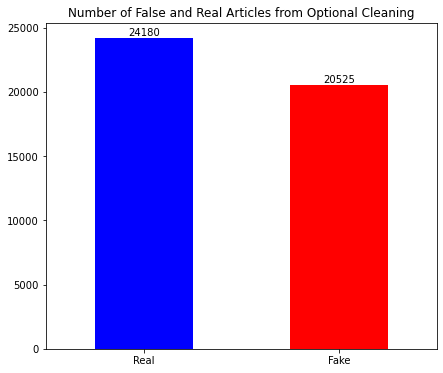

In [14]:
### Showing plot of the number of False or Real Articles
### We can see that there are more real than fake news articles in our data

ax= news['label'].value_counts().plot(kind= 'bar',
                                      rot= 0,
                                      figsize= (7, 6),
                                      title= 'Number of False and Real Articles from Optional Cleaning',
                                      color= ('b', 'r'))
ax.set_xticklabels(('Real', 'Fake'))

for rect in ax.patches:
    y_value = rect.get_height()
    x_value = rect.get_x() + rect.get_width() / 2
    space = 1
    label = "{:.0f}".format(y_value)
    ax.annotate(label, (x_value, y_value), xytext=(0, space), textcoords="offset points", ha='center', va='bottom')

plt.show()

In [15]:
###

#This section is reduces the data to 25% of the variables and resets the index. 
#The new variable is called news_consol. 

news_consol = news.groupby('label', group_keys=False).apply(lambda x: x.sample(frac=0.25)).reset_index(drop= True)
news_consol.head(10)

title  \
0       Trump win boosts coal, hits renewable stocks   
1  Furious Philippines decries West's joint stand...   
2  Trump nominates Columbia professor Jackson for...   
3  Vatican treasurer to face March court hearing ...   
4  U.S. officials say about 5-6 million customers...   
5  China says regional cooperation should not be ...   
6  U.S. panel probing Benghazi attack to report w...   
7  In clash of billionaires, Bloomberg calls Trum...   
8  Chattanooga shooting: History of attacks on U....   
9  Role of tech who set up Clinton's server unkno...   

                                                text label  
0  MARRAKESH, Morocco/CHICAGO (Reuters) - The pro...     0  
1  MANILA (Reuters) - The Philippines vigorously ...     0  
2  WASHINGTON (Reuters) - President Donald Trump ...     0  
3  MELBOURNE (Reuters) - Vatican treasurer Cardin...     0  
4  WASHINGTON (Reuters) - Five million to 6 milli...     0  
5  BEIJING (Reuters) - China said on Monday that ...     0  
6  WASHINGTON (Reuters) - The U.S. House panel in...     0  
7  PHILADELPHIA (Reuters) - New York media mogul ...     0  
8  Peter Bergen is CNN's national security analys...     0  
9  NEW YORK (Reuters) - Soon after Hillary Clinto...     0

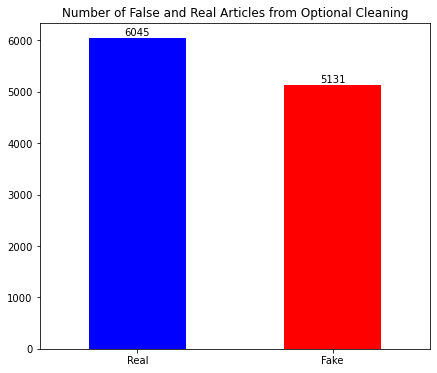

In [16]:
ax= news_consol['label'].value_counts().plot(kind= 'bar',
                                      rot= 0,
                                      figsize= (7, 6),
                                      title= 'Number of False and Real Articles from Optional Cleaning',
                                      color= ('b', 'r'))
ax.set_xticklabels(('Real', 'Fake'))

for rect in ax.patches:
    y_value = rect.get_height()
    x_value = rect.get_x() + rect.get_width() / 2
    space = 1
    label = "{:.0f}".format(y_value)
    ax.annotate(label, (x_value, y_value), xytext=(0, space), textcoords="offset points", ha='center', va='bottom')

plt.show()

This graph when compared to the whole set shows similar proportionality between the real and the fake data. 

There were approximately 6500 duplicated stories. The text was cleaned based on the body of the article. This indicates there was overlap between the two data sets and within the Truth and Fake data. Initially the data was split approximately 50/50. In the Data Exploration section the data will be examined to validate the mix between true and fake articles is still approximately 50/50.

#### The following cleaning steps optional. 
During final analysis, will determine if the additional cleaning helped build a stronger model. Each step can be operated independently or sequentially. Each cleaning step will have two variables. The first variable will pull from the previous cleaning step. The second variable will pull from the news set only. This direct change from the news dataframe will have the label '_only'. This will be used for comparison later. 
This cleaning will be applied to the text only. There is commented out steps if the user wants to apply changes to title column in data frame as well

In [17]:
#This step will convert all text to lowercase. 
#Goal is to make text consistent to make it easier to identify repeated words and patterns
news_lc = news_consol.copy()
news_lc['text']=news_lc['text'].apply(lambda x:x.lower())

news_lc.head()

title  \
0       Trump win boosts coal, hits renewable stocks   
1  Furious Philippines decries West's joint stand...   
2  Trump nominates Columbia professor Jackson for...   
3  Vatican treasurer to face March court hearing ...   
4  U.S. officials say about 5-6 million customers...   

                                                text label  
0  marrakesh, morocco/chicago (reuters) - the pro...     0  
1  manila (reuters) - the philippines vigorously ...     0  
2  washington (reuters) - president donald trump ...     0  
3  melbourne (reuters) - vatican treasurer cardin...     0  
4  washington (reuters) - five million to 6 milli...     0

In [18]:
#This step will remove stopwords in the articles. 
#This step removes stop words to reduce the data set size. 

stop_words = set(stopwords.words('english'))
news_stop = news_lc.copy()
news_stop['text'] = news_stop['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in stop_words]))

news_stop.head()

title  \
0       Trump win boosts coal, hits renewable stocks   
1  Furious Philippines decries West's joint stand...   
2  Trump nominates Columbia professor Jackson for...   
3  Vatican treasurer to face March court hearing ...   
4  U.S. officials say about 5-6 million customers...   

                                                text label  
0  marrakesh, morocco/chicago (reuters) - prospec...     0  
1  manila (reuters) - philippines vigorously defe...     0  
2  washington (reuters) - president donald trump ...     0  
3  melbourne (reuters) - vatican treasurer cardin...     0  
4  washington (reuters) - five million 6 million ...     0

In [19]:
#This step will remove stopwords in the articles. 
#This step removes stop words to reduce the data set size. 

stop_words = set(stopwords.words('english'))
news_stop = news_lc.copy()
news_stop['text'] = news_stop['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in stop_words]))

news_stop.head()

title  \
0       Trump win boosts coal, hits renewable stocks   
1  Furious Philippines decries West's joint stand...   
2  Trump nominates Columbia professor Jackson for...   
3  Vatican treasurer to face March court hearing ...   
4  U.S. officials say about 5-6 million customers...   

                                                text label  
0  marrakesh, morocco/chicago (reuters) - prospec...     0  
1  manila (reuters) - philippines vigorously defe...     0  
2  washington (reuters) - president donald trump ...     0  
3  melbourne (reuters) - vatican treasurer cardin...     0  
4  washington (reuters) - five million 6 million ...     0

In [20]:
#This step will tokenize the words 
#This will break the string into individual tokens
news_token = news_stop.copy()

news_token['text'] = news_token['text'].apply(lambda x: nltk.word_tokenize(x))

In [21]:
#This step will stem the words
#This step will help normalize the words to their root form. 
#The goal is to help reduce the dimensionality of the data frames

news_stem = news_token.copy()
stemmer = PorterStemmer()
news_stem['text'] = news_stem['text'].apply(lambda x: [stemmer.stem(word) for word in x])

news_stem.head()

title  \
0       Trump win boosts coal, hits renewable stocks   
1  Furious Philippines decries West's joint stand...   
2  Trump nominates Columbia professor Jackson for...   
3  Vatican treasurer to face March court hearing ...   
4  U.S. officials say about 5-6 million customers...   

                                                text label  
0  [marrakesh, ,, morocco/chicago, (, reuter, ), ...     0  
1  [manila, (, reuter, ), -, philippin, vigor, de...     0  
2  [washington, (, reuter, ), -, presid, donald, ...     0  
3  [melbourn, (, reuter, ), -, vatican, treasur, ...     0  
4  [washington, (, reuter, ), -, five, million, 6...     0

In [22]:
#This step will lemmatize the words
#This step is to help reduce the dimensionality of the data frame


news_lem = news_stem.copy()

lemmatizer = WordNetLemmatizer()
news_lem['text'] = news_lem['text'].apply(lambda x: [lemmatizer.lemmatize(word) for word in x])

news_lem.head()

title  \
0       Trump win boosts coal, hits renewable stocks   
1  Furious Philippines decries West's joint stand...   
2  Trump nominates Columbia professor Jackson for...   
3  Vatican treasurer to face March court hearing ...   
4  U.S. officials say about 5-6 million customers...   

                                                text label  
0  [marrakesh, ,, morocco/chicago, (, reuter, ), ...     0  
1  [manila, (, reuter, ), -, philippin, vigor, de...     0  
2  [washington, (, reuter, ), -, presid, donald, ...     0  
3  [melbourn, (, reuter, ), -, vatican, treasur, ...     0  
4  [washington, (, reuter, ), -, five, million, 6...     0

In [23]:
#This step will remove numbers and special characters.
#Punction can be removed because it does not carry semantic meaning

news_nonum = news_lem.copy()

#news_nonum['text'] = news_nonum['text'].apply(lambda x: [word for word in x if word.isalpha()])

def cleanup(text):
    clean_text = [re.sub(r"[^a-z]+", ' ', i) for i in text]
    return clean_text

for i in range(len(news_nonum)):
    news_nonum['text'][i] = cleanup(news_nonum['text'][i])

In [24]:
# join the tokens back into a single string

news_com = news_nonum.copy()
news_com.head()


title  \
0       Trump win boosts coal, hits renewable stocks   
1  Furious Philippines decries West's joint stand...   
2  Trump nominates Columbia professor Jackson for...   
3  Vatican treasurer to face March court hearing ...   
4  U.S. officials say about 5-6 million customers...   

                                                text label  
0  [marrakesh,  , morocco chicago,  , reuter,  , ...     0  
1  [manila,  , reuter,  ,  , philippin, vigor, de...     0  
2  [washington,  , reuter,  ,  , presid, donald, ...     0  
3  [melbourn,  , reuter,  ,  , vatican, treasur, ...     0  
4  [washington,  , reuter,  ,  , five, million,  ...     0

### Data Exploration

In [25]:
### Looking at the shape of the news data

print("News combined shape", news_com.shape)

News combined shape (11176, 3)


The two data frames are the same shape. This is expected since there were no additional row operations after removing duplicates. 

In [26]:
### Looking at the basic information of both the news and combined news data

news_com.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11176 entries, 0 to 11175
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   title   11176 non-null  object
 1   text    11176 non-null  object
 2   label   11176 non-null  object
dtypes: object(3)
memory usage: 262.1+ KB


In [27]:
### Using the describe function, we look at a quick description of the combined news data

news_com.describe()

title  \
count                                               11176   
unique                                              11143   
top     Factbox: Contenders for senior jobs in Trump's...   
freq                                                    4   

                                                     text  label  
count                                               11176  11176  
unique                                              11173      2  
top     [notifi, follow up, comment, email,  , notifi,...      0  
freq                                                    4   6045

### Build a Latent Dirichlet Allocation (LDA)

In [28]:
###This step creates a dictionary from the text column using the Gensim python library
#This dictionary will be used to create a bag of words vectors for each article

dictionary = gensim.corpora.Dictionary(news_com['text'])

In [29]:
###This step creates a bag of words representation of the text data in the text column
#Creates a vocabulary of words used in the text data. 
#This creates a list of tuples and is stored in the bow_corpus variable

bow_corpus = [dictionary.doc2bow(doc) for doc in news_com['text']]
bow_corpus

[[(0, 128),
  (1, 1),
  (2, 1),
  (3, 1),
  (4, 1),
  (5, 3),
  (6, 2),
  (7, 1),
  (8, 1),
  (9, 1),
  (10, 2),
  (11, 1),
  (12, 1),
  (13, 1),
  (14, 1),
  (15, 1),
  (16, 2),
  (17, 1),
  (18, 1),
  (19, 1),
  (20, 1),
  (21, 1),
  (22, 1),
  (23, 1),
  (24, 1),
  (25, 1),
  (26, 1),
  (27, 1),
  (28, 1),
  (29, 1),
  (30, 4),
  (31, 2),
  (32, 1),
  (33, 1),
  (34, 1),
  (35, 6),
  (36, 1),
  (37, 1),
  (38, 2),
  (39, 7),
  (40, 1),
  (41, 1),
  (42, 1),
  (43, 9),
  (44, 1),
  (45, 1),
  (46, 1),
  (47, 1),
  (48, 1),
  (49, 3),
  (50, 3),
  (51, 1),
  (52, 1),
  (53, 1),
  (54, 1),
  (55, 1),
  (56, 1),
  (57, 1),
  (58, 3),
  (59, 1),
  (60, 1),
  (61, 1),
  (62, 1),
  (63, 1),
  (64, 1),
  (65, 1),
  (66, 1),
  (67, 1),
  (68, 1),
  (69, 1),
  (70, 1),
  (71, 1),
  (72, 1),
  (73, 1),
  (74, 4),
  (75, 3),
  (76, 5),
  (77, 1),
  (78, 2),
  (79, 1),
  (80, 1),
  (81, 1),
  (82, 1),
  (83, 1),
  (84, 1),
  (85, 1),
  (86, 1),
  (87, 2),
  (88, 1),
  (89, 1),
  (90, 1),
  (91, 

In [30]:
###This reflects the importance of a word in the bow_corpus
#This counts the numbers of times a word appears in a document as well as the corpus
#A higher score means that the words are more important

tfidf = models.TfidfModel(bow_corpus)
corpus_tfidf = tfidf[bow_corpus]

In [31]:
###

'''for doc in corpus_tfidf:
    print(doc)'''

'for doc in corpus_tfidf:\n    print(doc)'

In [32]:
###This splits the topics into 12 topics and ranks each word in the corpus. 
#Num_topics specifies the numbers number of topic and id2word provides word mapping
#This model is looking at the bow_corpus. 

lda_model_bow = gensim.models.LdaMulticore(bow_corpus, num_topics= 12, id2word=dictionary, passes=2, workers=2)

for idx, topic in lda_model_bow.print_topics(-1):
    print('Topic: {} \nWords: {}'.format(idx+1, topic))

Topic: 1 
Words: 0.018*" " + 0.001*"trump" + 0.001*"would" + 0.001*"state" + 0.001*"clinton" + 0.001*"said" + 0.001*"one" + 0.001*"govern" + 0.001*"obama" + 0.001*"presid"
Topic: 2 
Words: 0.079*" " + 0.005*"said" + 0.004*"trump" + 0.003*"state" + 0.003*"peopl" + 0.003*"would" + 0.002*"one" + 0.002*"presid" + 0.002*"obama" + 0.002*"parti"
Topic: 3 
Words: 0.127*" " + 0.009*"trump" + 0.005*"peopl" + 0.004*"would" + 0.004*"said" + 0.004*"muslim" + 0.004*"one" + 0.003*"like" + 0.003*"also" + 0.003*"woman"
Topic: 4 
Words: 0.147*" " + 0.010*"said" + 0.007*"state" + 0.006*"trump" + 0.005*"u s " + 0.005*"would" + 0.004*"peopl" + 0.004*"unit" + 0.004*"govern" + 0.003*"countri"
Topic: 5 
Words: 0.027*" " + 0.001*"said" + 0.001*"state" + 0.001*"govern" + 0.001*"duggar" + 0.001*"u s " + 0.001*"report" + 0.001*"sexual" + 0.001*"molest" + 0.001*"one"
Topic: 6 
Words: 0.007*" " + 0.002*"trump" + 0.000*"presid" + 0.000*"time" + 0.000*"donald" + 0.000*"clinton" + 0.000*"one" + 0.000*"like" + 0.000*"w

The 12 topics all have a space as the leading important variable. There are some additional filler words which came through such as http.

The Topics can broadly be grouped into a few categories.
Topic 1: Politics - mentions of Trump, Clinton, Obama, and the presidency
Topic 2: General News - mentions of people, Trump, and politics
Topic 3: Social Issues - mentions of Trump, Muslims, women, and diversity
Topic 4: National News - mentions of the US, government, and politics
Topic 5: Crime and Justice - mentions of sexual abuse and molestation
Topic 6: General News - mentions of Trump, politics, and race
Topic 7: General News - mentions of Trump, the US, and politics
Topic 8: International News - mentions of Trump, North Korea, China, and other countries
Topic 9: International News - mentions of Syria, Iran, and the US
Topic 10: Politics - mentions of Trump, Republicans, and the presidency
Topic 11: Politics - mentions of Clinton, emails, and the FBI investigation
Topic 12: General News - mentions of Trump, Democrats, and American issues

There are 3 instances of politics (Topic 1, 10, & 11). Topic 1 is focused on presidential candidates. Topic 10 is focused on the parties. Topic 11 is focused the Clinton Email investigation. There are 4 instances of general news (Topics 2, 6, 7, & 12). There are two instances of International News (Topics 8 & 9). Topic 8 is focused on Asian News. Topic 9 is focused on middle eastern news. 

In [33]:
###This shows the first topic for the LDA 

lda_model_bow.show_topic(0)

[(' ', 0.01840726),
 ('trump', 0.0011636482),
 ('would', 0.0010353127),
 ('state', 0.0009399446),
 ('clinton', 0.0008752672),
 ('said', 0.00084554567),
 ('one', 0.0008344629),
 ('govern', 0.0007934725),
 ('obama', 0.0007821075),
 ('presid', 0.00078113127)]

This looks at the top 9 words in this topic. The space is the one of words and is an opportunity for improvement in the cleaning. 

In [34]:
###This code loops through the 12 topics and cleanly prints the words in each topic. 

for i in range(0, 12):
  l = lda_model_bow.show_topic(i)
  print("\n\nTopic "+ str(i+1))  
  for i in range(len(l)):
    print(l[i][0])



Topic 1
 
trump
would
state
clinton
said
one
govern
obama
presid


Topic 2
 
said
trump
state
peopl
would
one
presid
obama
parti


Topic 3
 
trump
peopl
would
said
muslim
one
like
also
woman


Topic 4
 
said
state
trump
u s 
would
peopl
unit
govern
countri


Topic 5
 
said
state
govern
duggar
u s 
report
sexual
molest
one


Topic 6
 
trump
presid
time
donald
clinton
one
like
would
white


Topic 7
 
trump
s
said
one
state
presid
would
also
u s 


Topic 8
 
trump
said
state
north
one
korea
s
china
would


Topic 9
 
said
state
syria
would
u s 
syrian
s
govern
iran


Topic 10
 
trump
said
s
presid
would
state
peopl
republican
one


Topic 11
 
clinton
email
fbi
investig
hillari
said
trump
state
s


Topic 12
 
trump
said
http
american
franken
clinton
state
peopl
democrat


In [35]:
###This topic is using the Term Frequency-Inverse Document Frequency (TF-IDF) representation of the corpus
#representing text data that takes into account the importance of each word in a document 
#relative to its frequency in the entire corpus

lda_model_tfidf = gensim.models.LdaMulticore(corpus_tfidf, num_topics= 12, id2word=dictionary, passes=2, workers=4)
for idx, topic in lda_model_tfidf.print_topics(-1):
    print('Topic: {} \nWord: {}'.format(idx, topic))

Topic: 0 
Word: 0.001*"trump" + 0.001*"clinton" + 0.001*"s" + 0.001*"republican" + 0.001*"hillari" + 0.001*"obama" + 0.001*"peopl" + 0.001*"investig" + 0.001*"presid" + 0.001*"democrat"
Topic: 1 
Word: 0.004*"trump" + 0.002*"clinton" + 0.002*"s" + 0.001*"republican" + 0.001*"hillari" + 0.001*"obama" + 0.001*"fbi" + 0.001*"comey" + 0.001*"white" + 0.001*"vote"
Topic: 2 
Word: 0.001*"trump" + 0.001*"s" + 0.001*"clinton" + 0.001*"republican" + 0.001*"vote" + 0.000*"u s " + 0.000*"senat" + 0.000*"obama" + 0.000*"state" + 0.000*"hillari"
Topic: 3 
Word: 0.002*"trump" + 0.002*"s" + 0.002*"clinton" + 0.001*"republican" + 0.001*"tax" + 0.001*"obama" + 0.001*"senat" + 0.001*"sander" + 0.001*"hillari" + 0.001*"cruz"
Topic: 4 
Word: 0.001*"trump" + 0.001*"boiler" + 0.001*"acr" + 0.001*"pm" + 0.001*"s" + 0.001*"republican" + 0.001*"clinton" + 0.000*"room" + 0.000*"radio" + 0.000*"presid"
Topic: 5 
Word: 0.001*"trump" + 0.001*"s" + 0.001*"clinton" + 0.001*"obama" + 0.001*"vote" + 0.001*"polic" + 0.

It seems like the topics generated by the LDA model are related to politics and news. 
Topic 0 seems to be related to political figures like Trump, Clinton, and Obama.
Topic 1 is focused on investigations related to the US government. 
Topic 2 and 3 seem to be related to politics as well, with mentions of taxes, senate, and voting. 
Topic 4 seems to be unrelated to politics and could be an anomaly. 
Topic 5 is related to law enforcement and voting. 
Topic 6 is focused on political parties and elections. 
Topic 7 is focused on foreign relations, particularly with North Korea and China. 
Topic 8 is also related to international relations, mentioning countries like China, Saudi Arabia, and the United States. 
Topic 9 and 11 are related to politics and voting. 
Topic 10 is focused on international relations with mentions of countries like Russia and the European Union. 

Overall, it seems like the model has successfully generated topics related to politics and news.

In [36]:
###This code loops through the 12 topics and cleanly prints the words in each topic. 


for i in range(0, 12):
  l = lda_model_tfidf.show_topic(i)
  print("\n\nTopic "+ str(i+1))  
  for i in range(len(l)):
    print(l[i][0])



Topic 1
trump
clinton
s
republican
hillari
obama
peopl
investig
presid
democrat


Topic 2
trump
clinton
s
republican
hillari
obama
fbi
comey
white
vote


Topic 3
trump
s
clinton
republican
vote
u s 
senat
obama
state
hillari


Topic 4
trump
s
clinton
republican
tax
obama
senat
sander
hillari
cruz


Topic 5
trump
boiler
acr
pm
s
republican
clinton
room
radio
presid


Topic 6
trump
s
clinton
obama
vote
polic
presid
democrat
state
republican


Topic 7
trump
s
republican
vote
clinton
cruz
parti
elect
democrat
campaign


Topic 8
trump
s
u s 
korea
north
white
china
said
presid
state


Topic 9
trump
s
china
clinton
u s 
state
obama
presid
saudi
unit


Topic 10
trump
s
clinton
vote
republican
elect
senat
obama
u s 
campaign


Topic 11
trump
korea
s
north
clinton
eu
russia
russian
u s 
state


Topic 12
trump
clinton
obama
s
woman
hillari
republican
senat
hous
presid


lda_model_bow uses the bag-of-words (BoW) representation of the documents in bow_corpus
lda_model_tfidf uses the TF-IDF representation of the documents in corpus_tfidf.

The TF-IDF topic segregration is slightly different than the Bag of Words model. 

Topics 1, 2, 3, 4, 6, 7, 10, and 12 have some common words across both models such as "trump", "s", "clinton", "republican", "obama", "vote", and "presid". However, topics 5, 8, 9, and 11 have different sets of words in each model.

In [37]:
###This code computes the perplexity and coherence score of the LDA model trained on the Bag-of-Words corpus bow_corpus.

print('Perplexity: ', round(lda_model_bow.log_perplexity(bow_corpus), 2))

coherence_model_lda = CoherenceModel(model=lda_model_bow, texts= 
                                     news_com['text'], dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('Coherence Score: ', round(coherence_lda, 2))

Perplexity:  -7.24
Coherence Score:  0.32


In [38]:
######This code computes the perplexity and coherence score of the LDA model trained on the TFIDF

print('Perplexity: ', round(lda_model_tfidf.log_perplexity(corpus_tfidf), 2))
coherence_model_lda = CoherenceModel(model=lda_model_tfidf, texts= news_com['text'], dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('Coherence Score: ', round(coherence_lda, 2))

Perplexity:  -12.27
Coherence Score:  0.41


The perplexity value measures how well the model predicts new unseen documents. A lower perplexity value indicates better performance.

The coherence value measures how interpretable and coherent the topics are. A higher coherence value indicates better performance.

Comparing the two models, it seems that the LDA model trained on the TF-IDF corpus performs better in terms of perplexity, as it has a lower perplexity value. However, the LDA model trained on the BOW corpus performs better in terms of coherence, as it has a higher coherence value.

It's worth noting that the choice of corpus and hyperparameters can have a significant impact on the performance of an LDA model, and that different evaluation metrics may be appropriate depending on the goals of the analysis.

In [39]:
###

def format_topics_sentences(ldamodel=None, corpus=bow_corpus, texts=news_com['text']):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)

In [40]:
###

df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model_tfidf, corpus=corpus_tfidf, texts=news_com['text'])

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic

C:\Users\tymbo\AppData\Local\Temp\ipykernel_23096\3830197282.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
C:\Users\tymbo\AppData\Local\Temp\ipykernel_23096\3830197282.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)


Document_No  Dominant_Topic  Topic_Perc_Contrib  \
0                0               1              0.9210   
1                1               1              0.7094   
2                2               3              0.8883   
3                3               1              0.8568   
4                4               1              0.4744   
...            ...             ...                 ...   
11171        11171               1              0.8865   
11172        11172               1              0.9175   
11173        11173               1              0.7433   
11174        11174               1              0.9017   
11175        11175               1              0.6776   

                                                Keywords  \
0      trump, clinton, s, republican, hillari, obama,...   
1      trump, clinton, s, republican, hillari, obama,...   
2      trump, s, clinton, republican, tax, obama, sen...   
3      trump, clinton, s, republican, hillari, obama,...   
4      trump, clinton, s, republican, hillari, obama,...   
...                                                  ...   
11171  trump, clinton, s, republican, hillari, obama,...   
11172  trump, clinton, s, republican, hillari, obama,...   
11173  trump, clinton, s, republican, hillari, obama,...   
11174  trump, clinton, s, republican, hillari, obama,...   
11175  trump, clinton, s, republican, hillari, obama,...   

                                                    Text  
0      [marrakesh,  , morocco chicago,  , reuter,  , ...  
1      [manila,  , reuter,  ,  , philippin, vigor, de...  
2      [washington,  , reuter,  ,  , presid, donald, ...  
3      [melbourn,  , reuter,  ,  , vatican, treasur, ...  
4      [washington,  , reuter,  ,  , five, million,  ...  
...                                                  ...  
11171  [plenti, politician, mani, stripe, afraid, ide...  
11172  [ ,  ,  , plan, farmer,  , s, calendar, year, ...  
11173  [great, flashback, claim, crystal, ball, nomin...  
11174  [q , trump, win, consid, repudi, nation, news,...  
11175  [late night, tv, host, jimmi, kimmel, open, pr...  

[11176 rows x 5 columns]

In [41]:
###

vis = pyLDAvis.gensim.prepare(topic_model= lda_model_tfidf, corpus= corpus_tfidf, dictionary=dictionary)
pyLDAvis.enable_notebook()
pyLDAvis.display(vis)

c:\Users\tymbo\Anaconda3\envs\tybo\lib\site-packages\pyLDAvis\_prepare.py:243: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(
